
# MediChal Challenge - Detecting Malaria with cell Images

____

<img src="./logo.jpg" width="200" height="200" align="left"> 

## Team MEDICHAL :
- Théo Deschamps-Berger
- Simon Monteiro
- Xienneng Xu
- Nicolas Devatine
- Clément Veyssière
- Corentin Leloup
- Ramine Hamidi


<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
        <br>       
 
     
The problem we try to solve here is the diagnosis of malaria using images of cells that are whether infected or not. It is a binary classification problem from the data set found here at <a href=https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria>"Cell images for detecting malaria"</a>. The data set contains around 27 thousand images, that are balanced between the 2 classes. The way we proceed here is to extract features from the images instead of using images directly as inputs to the model we use for predictions.

 
</div>

<p align="center">
  <img src="example_cells.png">
</p>
<center>Example of parasitized and uninfected cells</center>

In [14]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

### Quality of the data

Our data is composed of images that we preprocessed to extract features. Therefore we do not have any missing data in any feature because we created the features ourselves. There may be one artefact which is the fact that the background is black, and we may wonder if infected cells might be smaller (or the contrary), which would provide us darker images and a higher (or lower) average of gray 

In [2]:
data_dir = 'sample_data'              # Change this to the directory where you put the input data
#data_dir = '../FILES/iris/'          # The sample_data directory should contain only a very small subset of the data
data_name = 'malaria'
!ls $data_dir*

malaria_feat.name     malaria_test.data       malaria_valid.data
malaria_label.name    malaria_test.solution   malaria_valid.solution
malaria_private.info  malaria_train.data
malaria_public.info   malaria_train.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [33]:
from data_io import read_as_df
import numpy as np
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame
print("Number of parasitized cells =",np.sum(data.target == 'parasitized'))
print("Number of uninfected cells =",np.sum(data.target == 'uninfected'))

Reading sample_data/malaria_train from AutoML format
Number of examples = 16534
Number of features = 19
         Class
0   uninfected
1  parasitized
Number of classes = 2
Number of parasitized cells = 8276
Number of uninfected cells = 8258


In [34]:
data.head()

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0,target
0,4884,0.000000,0.948893,0.948893,0.948893,0.419515,0.636039,0.529412,0.764706,0,0,0,0,0,0,0,1038,9482,1886,uninfected
1,4347,0.000311,0.907223,0.874799,0.927769,0.519111,0.633702,0.400000,0.823529,0,0,0,0,0,1,79,6716,4333,656,parasitized
2,4935,0.000033,0.972043,0.962162,0.985586,0.266897,0.641619,0.568627,0.737255,0,0,0,0,0,0,0,0,8647,4506,uninfected
3,6501,0.000017,0.955153,0.950617,0.959436,0.594517,0.661221,0.301961,0.745098,0,0,0,0,4,25,122,367,8520,5813,parasitized
4,3384,0.000189,0.870487,0.857143,0.911565,2.217611,0.471401,0.345098,0.780392,0,0,0,0,0,1966,2513,1448,798,191,uninfected


We have decided to reduce the dataset of images to a simpler dataset with only 6 features. The feature `has_points` is boolean and indicates whether or not an image contains darker points. to detect this, we have 2 thresholds : the mean of the pixels values and the mean between this mean and the minimum value of the pixels. the feature value is 0 if there are no pixels with a value in these boundaries and 1 otherwise.

`black_pixels` counts pixels whose value is dark, those around the cell in the image

The `var_color` feature is simply the empirical variance of the values of the pixels and `max_color` the maximum.

The 2 other features are the same thing with the image in grayscale

In [35]:
data.describe() 

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0
count,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.0,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000
mean,5186.434861,0.000187,0.932538,0.915922,0.951003,0.455423,0.638756,0.425941,0.767492,0.0,0.023588,0.068828,0.825390,9.424398,39.726261,255.600641,1700.682533,7205.277186,3425.218157
std,2555.612474,0.000685,0.042827,0.050649,0.038777,0.401030,0.047318,0.166523,0.034910,0.0,2.398723,3.554840,10.868906,34.948790,148.352439,944.844381,2869.953967,4015.087123,3777.575870
min,720.000000,0.000000,0.361582,0.308397,0.361582,0.013198,0.399673,0.062745,0.564706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,3753.000000,0.000028,0.912136,0.892857,0.933333,0.169282,0.614504,0.262745,0.749020,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3781.000000,944.000000
50%,4641.000000,0.000070,0.942715,0.926871,0.960345,0.357243,0.646235,0.431373,0.764706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,190.000000,7634.500000,1913.000000
75%,5848.500000,0.000161,0.963064,0.950949,0.978261,0.614151,0.671711,0.592157,0.788235,0.0,0.000000,0.000000,0.000000,3.000000,49.000000,108.000000,1966.000000,10215.000000,4317.750000
max,79306.000000,0.030410,1.000000,1.000000,1.000000,7.691629,0.748599,0.705882,0.941176,0.0,295.000000,305.000000,1026.000000,1595.000000,5492.000000,12863.000000,17071.000000,29463.000000,30574.000000


Histogram of our features:

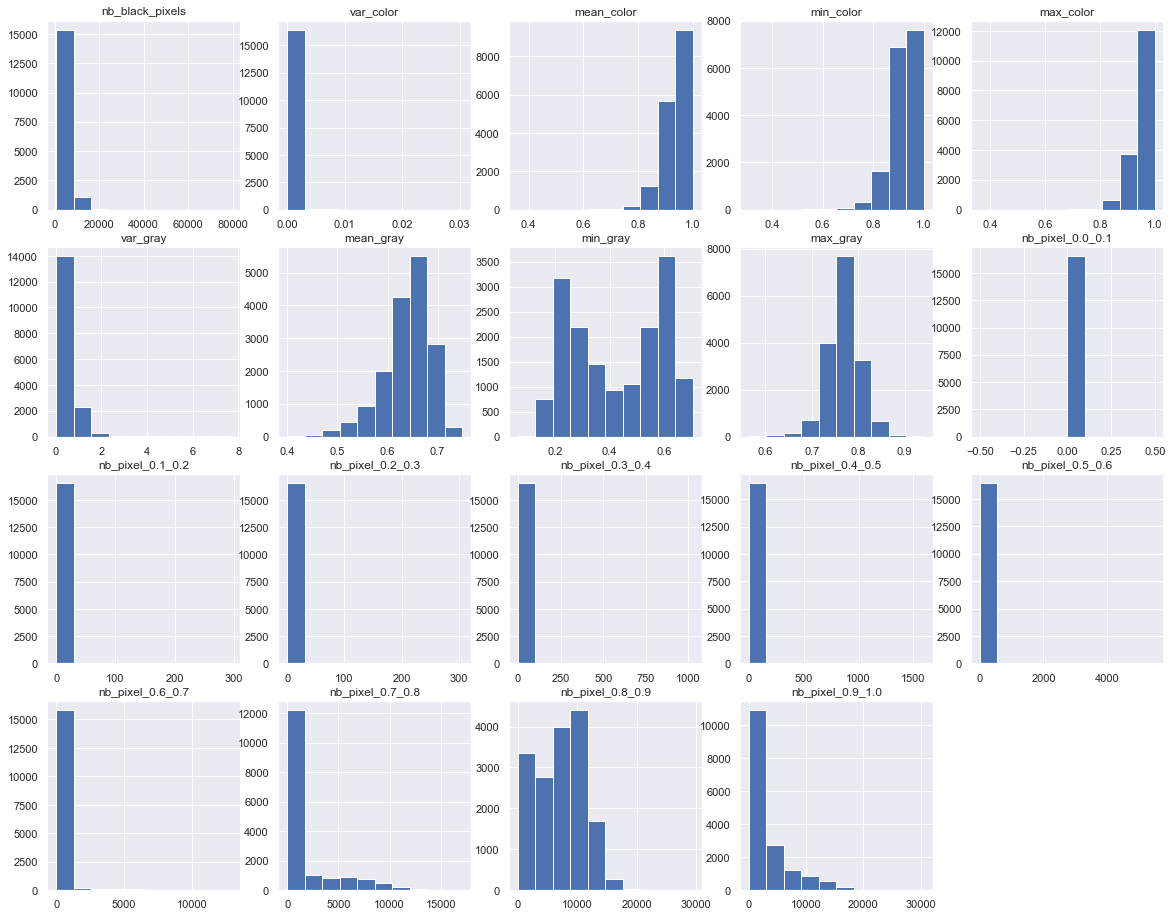

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))

for t in range(19):
    plt.subplot(4,5,t+1)
    plt.hist(data[data.columns[t]])
    plt.title(data.columns[t])
    t+=1

Correlation of our features with the target: 'parasitized'

In [47]:
import pandas as pd
d=pd.get_dummies(data['target'])['parasitized']

n_df = pd.merge(d, data, right_index=True, left_index=True)
df_n = new_df.select_dtypes(include=np.number)

df_n.corr()

,parasitized,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0
parasitized,1.000000,0.100477,0.046781,-0.197999,-0.177857,-0.210265,0.440838,-0.266705,-0.871959,-0.012854,NaN,-0.009592,0.004947,0.068459,0.256478,0.240366,0.152994,0.168525,0.047019,-0.194985
nb_black_pixels,0.100477,1.000000,-0.030570,0.034557,0.073478,-0.036797,-0.073044,0.219705,-0.085592,0.008297,NaN,0.021980,0.029312,0.017840,0.030424,0.004310,-0.068189,-0.104491,0.219559,0.348202
var_color,0.046781,-0.030570,1.000000,-0.282429,-0.475334,-0.028050,0.137628,-0.152356,-0.086753,0.059463,NaN,-0.002087,0.000151,0.017121,0.055116,0.100409,0.126825,0.140567,-0.050218,-0.107621
mean_color,-0.197999,0.034557,-0.282429,1.000000,0.954260,0.914975,-0.334417,0.437410,0.281407,-0.140403,NaN,0.002544,-0.001140,-0.047991,-0.133786,-0.203043,-0.262084,-0.376635,0.069324,0.398801
min_color,-0.177857,0.073478,-0.475334,0.954260,1.000000,0.781226,-0.351193,0.449546,0.267264,-0.161581,NaN,0.003579,0.000715,-0.046214,-0.132724,-0.211068,-0.282746,-0.398386,0.084316,0.405154
max_color,-0.210265,-0.036797,-0.028050,0.914975,0.781226,1.000000,-0.262118,0.349105,0.270918,-0.087486,NaN,-0.000517,-0.004041,-0.045191,-0.116718,-0.170052,-0.190446,-0.278585,0.029976,0.329213
var_gray,0.440838,-0.073044,0.137628,-0.334417,-0.351193,-0.262118,1.000000,-0.619262,-0.606560,0.217788,NaN,0.074152,0.179882,0.338849,0.591797,0.509401,0.542857,0.543406,-0.241599,-0.395960
mean_gray,-0.266705,0.219705,-0.152356,0.437410,0.449546,0.349105,-0.619262,1.000000,0.454241,0.269254,NaN,0.000083,-0.021247,-0.112426,-0.305813,-0.358731,-0.535885,-0.604321,0.283847,0.536185
min_gray,-0.871959,-0.085592,-0.086753,0.281407,0.267264,0.270918,-0.606560,0.454241,1.000000,0.034148,NaN,-0.021212,-0.037000,-0.121067,-0.368373,-0.311225,-0.234364,-0.313551,-0.042649,0.311339
max_gray,-0.012854,0.008297,0.059463,-0.140403,-0.161581,-0.087486,0.217788,0.269254,0.034148,1.000000,NaN,-0.000663,0.001771,0.003845,0.022521,0.044160,0.133104,0.299761,0.087546,-0.230292


Let's try to indentify patterns with a pairplot, which will maybe give us structures for each class depending on 2 features 

In [19]:
sns.pairplot(data, hue="target")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Error in callback <function flush_figures at 0x00000166EFB477B8> (for post_execute):


KeyboardInterrupt: 

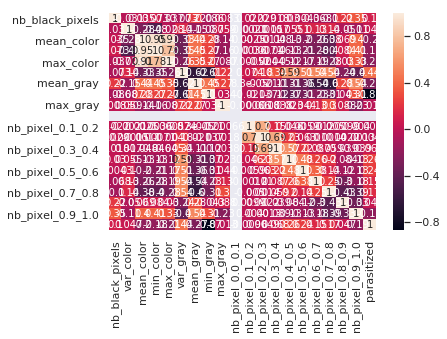

In [174]:
import pandas as pd
datatarget = pd.get_dummies(data['target'])['parasitized']
new_df = pd.merge(data, datatarget, right_index=True, left_index=True)
df_new = new_df.select_dtypes(include=np.number)
sns.heatmap(df_new.corr(), annot = True)

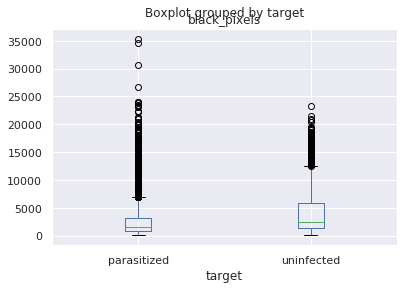

In [8]:
boxplot = data.boxplot(column=['black_pixels'], by='target', )

Let's have a closer look at the points in the cells

In [9]:
nb_par = data.target.value_counts()['parasitized']
data[data['target']=='parasitized'][data['has_points']==1].shape[0]/nb_par * 100

/home/ramine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


96.85416666666666

In [10]:
nb_un = data.target.value_counts()['uninfected']
data[data['target']=='uninfected'][data['has_points']==1].shape[0]/nb_par * 100

/home/ramine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


21.395833333333332

In the 2 previous cells we calculated the percentage of parasitized cells that have points and the percentage of uninfected cells that have points . For parasitized cells it is around 97% whereas for the uninfected cells it is around 21%. Therefore the is a strong correlation between the attribute "has_points" and the target.

There seem to have a little correlation between the number of black pixels and the target as well, which is data leakage as it is not suppose to differentiate each class.

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [49]:
from data_io import write
from model import model
# Uncomment the next line to show the code of the model
#??model 

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [50]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : C:\Users\Theo DB\Documents\AIC\ML_project_Guyon\MediChal - Copie\starting_kit\sample_data\malaria_public.info
DataManager : malaria
info:
	usage = Malaria cell images dataset
	name = malaria
	task = binary.classification
	target_type = Numerical
	feat_type = Numerical
	metric = roc_auc_score
	time_budget = 1200
	feat_num = 19
	target_num = 2
	label_num = 2
	train_num = 16534
	valid_num = 5512
	test_num = 5512
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(16534, 19)
	Y_train = array(16534,)
	X_valid = array(5512, 19)
	Y_valid = array(200,)
	X_test = array(5512, 19)
	Y_test = array(200,)
feat_type:	array(19,)
feat_idx:	array(0,)



In [51]:
#Trying a random forest model
M = model()   #The model is by default a random forest classifier
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [52]:
if not(M.is_trained):
    X_train = D.data['X_train']
    Y_train = D.data['Y_train']
    M.fit(X_train, Y_train)                     

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

FIT: dim(X)= [16534, 19]
FIT: dim(y)= [16534, 1]
PREDICT: dim(X)= [16534, 19]
PREDICT: dim(y)= [16534, 1]
PREDICT: dim(X)= [5512, 19]
PREDICT: dim(y)= [5512, 1]
PREDICT: dim(X)= [5512, 19]
PREDICT: dim(y)= [5512, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [53]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

We use the area under the curve as our metric to evaluate our model for the moment. We chose this metric because accuracy gives us only the percentage of correctly classified examples, whereas what we are interested in is to have the lowest possible rate of false negatives (infected cells classifies as being healthy). The ROC curve we will get will help us to find a good threshold for this classification, which will not necessarily the one maximising the accuracy as the false negatives are critical in our case (but the true negatives can always be rechecked by experts). The AUC will then give us the general performance of our model given the fact that we want to maximize true positives and true negatives.

In [54]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: roc_auc_score


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [55]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the roc_auc_score metric = 0.9958
Ideal score for the roc_auc_score metric = 1.0000


You can add here other scores and result visualization.

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

array([[8252,    6],
       [  64, 8212]], dtype=int64)

In [ ]:
### Plotting the ROC with the model training on 2000 instances.


In [60]:
from sklearn.metrics import roc_curve, auc

probas_ = M.classifier.fit(D.data['X_train'][:2000], D.data['Y_train'][:2000].ravel()).predict_proba(D.data['X_train'][2000:])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(D.data['Y_train'][2000:].ravel(), probas_[:, 1])
roc_auc = auc(fpr, tpr)

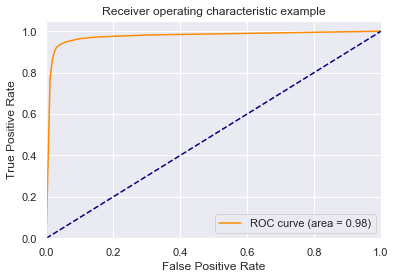

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This plot of the ROC curve is a good indicator for us to find a good threshold for our model, here we will prefer a very low rate of false negatives (1 - true positives rate). If we really want something near to 100% true positives, we might consider a model giving us 40% of false positive rate, we might consider that threshold as a medical diagnosis is a critical application.

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [62]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
M= model ()
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
scores

array([0.9536122 , 0.95384373, 0.94671811, 0.95639702, 0.95031821])

In [66]:
data2 = data.drop(['nb_black_pixels'], axis=1)
X_train2 = data2.drop(['target'], axis= 1)
X_train2
M = model()
scores = cross_val_score(M, X_train2, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score without the black_pixels attribute (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
scores

array([0.95146811, 0.95263833, 0.94883625, 0.95395398, 0.95033651])

The scores of our model with and without the black_pixels attribute is the same. Therefore we can conclude that there is no data leakage.

____

### Feature importance

The advantage of using a Random forest models is that we can evaluate which feature in taken into account  when predicting the target classes, here you can have an idea of which feature was the most relevant for solving our task

In [68]:
import pandas as pd

feature_importance = pd.DataFrame(M.classifier.feature_importances_,index= list(data)[:19], columns=['feature importance']).sort_values('feature importance', ascending = False)
feature_importance

,feature importance
min_gray,0.384790
nb_pixel_0.5_0.6,0.233291
nb_pixel_0.7_0.8,0.108937
nb_pixel_0.6_0.7,0.091364
var_gray,0.053268
nb_pixel_0.9_1.0,0.023430
mean_gray,0.015539
var_color,0.013730
max_color,0.012873
nb_black_pixels,0.012719




<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [24]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/sh: 1: source: not found
Using input_dir: /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/sample_data
Using output_dir: /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/sample_result_submission
Using program_dir: /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/ingestion_program
Using submission_dir: /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Malaria ********
************************************************
========= Reading and converting data ==========
Info file found : /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/sample_data/malaria_public.info
========= Reading /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/sample_data/malaria_feat.type
[+] Success in  0.00 sec
========= Reading /home/ramine/Bureau/AIC/MediChal-master (2)/starting_kit/sample_data/malaria_train.data
R

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [25]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

======= Set 1 (Malaria_test): roc_auc_score(set1_score)=0.869806101757 =======
======= Set 2 (Malaria_train): roc_auc_score(set2_score)=0.991145833333 =======
======= Set 3 (Malaria_valid): roc_auc_score(set3_score)=0.868614086754 =======


## Parameter optimization to try to improve the area under the roc curve.

In [69]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

import os
import sys
sys.stdout = open(os.devnull, 'w')

# Define the hyperparameters
hyperparameters = {
    'max_depth': [5, 10, 20,40], 
    'n_estimators' : [2,10, 20, 100] }

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))

# Just a table to save the results
#resultsDF = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])
resultsDF = pd.DataFrame()

for parameter_combination in parameter_grid:    
    clf = RandomForestClassifier (random_state = 42, n_estimators =parameter_combination['n_estimators'],max_depth =parameter_combination['max_depth'])
    M = model (classifier=clf)
    
    
    scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    
    
    parameter_combination['auc'] = scores.mean()
    
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
res = resultsDF.sort_values(by=['auc'], ascending=False)


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [27]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)